# Proyecto 1 - Analítica de Textos (G16)
- Daniel Arango Cruz ( d.arangoc2 )
- Javier Cerino Pulido ( j.cerino )
- Marco Zuliani Escalante ( m.zuliani )

## Caso

La Organización de las Naciones Unidas (ONU) adopta, el 25 de septiembre del año 2015, la Agenda 2030i para el desarrollo sostenible, cuyo fin es reducir la pobreza, garantizar acceso a la salud y educación, buscar igualdad de género y oportunidades, disminuir el impacto ambiental, entre otros. Esta agenda se basa en 17 objetivos de desarrollo sostenibleii (ODS) y 169 metas (derivadas de los diferentes ODS). 

## Objetivo
El objetivo es desarrollar un modelo de clasificación, con técnicas de aprendizaje automático, que permita relacionar de manera automática un texto según los ODS. Al igual que desarrollar una aplicación que facilite la interacción con el resultado de dicho modelo. El modelo podrá ser utilizado entonces para la interpretación y análisis de la información textual que es recopilada a través de diferentes fuentes por UNFPA en procesos de planeación participativa para el desarrollo a nivel territorial.

**Dado que somos el grupo 16, se abordarán los objetivos de desarrollo sostenible 6, 7 y 16.**

## 0. Import y configuración de dependencias

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import nltk

import ftfy

import re
from nltk.corpus import stopwords
from num2words import num2words
from nltk.tokenize import word_tokenize
from sklearn import linear_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_colwidth", None)

### Obtención de las stopwords en español
Palabras que no aportan información al análisis debido a su uso común y en cualquier contexto.

In [4]:
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## 1. Carga de datos

Se carga el archivo de datos asociado a los objetivos de desarrollo sostenible 6, 7 y 16.

In [6]:
data = pd.read_excel("data/cat_6716.xlsx")

Se revisa el numero de registros del dataframe

In [7]:
data.shape

(3000, 2)

Se revisan las columnas del dataframe

In [8]:
data.columns

Index(['Textos_espanol', 'sdg'], dtype='object')

Se revisan algunos registros del dataframe

In [9]:
data.head(6)

,Textos_espanol,sdg
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6
3,"Esto puede tener consecuencias sustanciales para la calidad del agua, especialmente en el río Mississippi y el norte del Golfo de México (De la Torre Ugarte et al., Si se requieren aportes de nutrientes para las plantaciones de madera, la infiltración y la escorrentía de nitrógeno también pueden representar un riesgo para las aguas subterráneas). (Lattimore et al., otra conclusión importante es que la ubicación de la producción y el tipo de producción de labranza, el sistema de rotación de cultivos y otras prácticas de gestión agrícola utilizadas en la producción de materias primas para la producción de bioenergía también influirán en gran medida en la calidad del agua (De la Torre Ugarte et al. ,",6
4,"La función de beneficio también incorpora parámetros que afectan a todos los usuarios, como los precios de insumos y productos y el clima.7 Por ejemplo, en un año seco, se espera que el beneficio de aplicar cualquier cantidad de agua a un cultivo sea mayor que en un año seco. año húmedo. La optimización óptima requeriría una valoración explícita de todos los posibles servicios ambientales asociados con el recurso de agua subterránea, tanto ahora como en el futuro. En cambio, la sociedad decide el nivel de servicios hidrológicos que es deseable y el problema económico es lograr ese nivel utilizando una solución que maximice los beneficios para los usuarios del agua.",6
5,"La descentralizaciÃ³n tambiÃ©n implica dar mayor protagonismo a los ComitÃ©s TÃ©cnicos de Aguas SubterrÃ¡neas (COTAS) en la gestiÃ³n de los acuÃferos, fortalecer la organizaciÃ³n y funcionamiento de los Consejos de Cuenca y sus Ã³rganos auxiliares, y consolidar las funciones de gobernanza y organizaciÃ³n regional de la CONAGUA. No existe un modelo Ãºnico para mejorar la gobernanza pÃºblica en el sector hÃdrico y superar los obstÃ¡culos institucionales para su implementaciÃ³n, p

A partir de la revisión de algunos registros, se identificó un problema de encoding. Este problema no permitía la correcta interpretación de las palabras y provocaba la aparición de caracteres extraños como se puede observar en el siguiente registro.

In [10]:
data.iloc[5]

Textos_espanol    La descentralizaciÃ³n tambiÃ©n implica dar mayor protagonismo a los ComitÃ©s TÃ©cnicos de Aguas SubterrÃ¡neas (COTAS) en la gestiÃ³n de los acuÃferos, fortalecer la organizaciÃ³n y funcionamiento de los Consejos de Cuenca y sus Ã³rganos auxiliares, y consolidar las funciones de gobernanza y organizaciÃ³n regional de la CONAGUA. No existe un modelo Ãºnico para mejorar la gobernanza pÃºblica en el sector hÃdrico y superar los obstÃ¡culos institucionales para su implementaciÃ³n, pero es fundamental diagnosticar los principales retos de gobernanza que se experimentan entre los ministerios y organismos pÃºblicos, entre los niveles de gobierno y entre los actores subnacionales, y revisar los instrumentos de gobernanza existentes. Esto ayudará a definir claramente las funciones y responsabilidades de las autoridades públicas y a establecer mecanismos de resolución de conflictos.
sdg                                                                                              

### Revisión sdg nulos

Se revisa si existe algún valor nulo. Especialmente si hay algún texto que no tenga clasificación y por lo tanto no sea útil para determinar los SDG de los textos al momento de entrenar el modelo.

In [11]:
data.isnull().sum()

Textos_espanol    0
sdg               0
dtype: int64

### Análisis de la distribución de los datos

In [12]:
data['sdg'].value_counts()

6     1000
7     1000
16    1000
Name: sdg, dtype: int64

Se puede observar que hay una distribución de 1/3 de los datos por cada una de las categorias a analizar. Este es un buen indicativo para realizar predicciones.

# 2. Corrección y preparación de datos

### Correción de palabras para eliminación de caracteres extraños

In [13]:
data['Textos_espanol'] = data['Textos_espanol'].astype(str)

Se hace uso de la libreria ftfy para la corrección de las palabras.

In [14]:
def fix_malformed_words(text):
    text = ftfy.fix_text(text)
    return text

data['Textos_espanol'] = data['Textos_espanol'].apply(fix_malformed_words)

Nuevamente se revisan algunos registros que presentaban palabras con caracteres extraños para confirmar la corrección de dichos errores de encoding. Ejemplo de esto es el registro número 6 en el que anteriormente aparecían tildes y acentos circunflejos extraños.

In [15]:
data.head(6)

,Textos_espanol,sdg
0,"Es importante destacar que, en un año de sequía, se espera que disminuyan todos los aportes, pero que aumente la demanda de agua de los cultivos y de la vegetación, lo que provocará una reducción del caudal de los ríos que están conectados hidrológicamente con el acuífero, así como una menor disponibilidad de agua para otros ecosistemas dependientes de las aguas subterráneas. Estas externalidades espaciales pueden incluir el agotamiento de los cursos de agua y el descenso del nivel freático local. Por ejemplo, el bombeo continuo del pozo B provocará el agotamiento de los cursos de agua y la reducción de su caudal.",6
1,"Hay una gran cantidad de literatura sobre Australia en esta área que sugiere fuertemente que el comercio de agua, especialmente en los mercados a corto plazo, no solo permite mitigar sustancialmente los impactos de las sequías en la agricultura, sino que ahora los agricultores lo consideran como un medio útil y básico. instrumento en su caja de herramientas de gestión de riesgos. Los desafíos políticos para Australia en el área de la regulación del agua en la agricultura están más en las áreas de cómo ajustar el sistema existente y los problemas de solidez relacionados con el cambio climático. Si bien el ejemplo australiano ilustra las posibles ganancias de eficiencia que surgen del comercio de agua, especialmente para gestionar la escasez de agua en circunstancias de sequía, la elección de un instrumento siempre debe considerar la gama completa de costos y beneficios.",6
2,"Los procesos de descentralización, emprendidos para una serie de actividades que antes realizaba el gobierno central, llevaron a modificaciones importantes en la forma en que se administraba y operaba el sector del agua. Las únicas excepciones a esta tendencia fueron Azerbaiyán, Bielorrusia y Turkmenistán, donde la gestión del sector del agua ha permanecido fuertemente centralizada. En Azerbaiyán, por ejemplo, la empresa nacional AZERSU JSC suministra agua al 65 % de la población, con un 10 % proporcionado por pequeños operadores privados y un 25 % por los propios hogares.",6
3,"Esto puede tener consecuencias sustanciales para la calidad del agua, especialmente en el río Mississippi y el norte del Golfo de México (De la Torre Ugarte et al., Si se requieren aportes de nutrientes para las plantaciones de madera, la infiltración y la escorrentía de nitrógeno también pueden representar un riesgo para las aguas subterráneas). (Lattimore et al., otra conclusión importante es que la ubicación de la producción y el tipo de producción de labranza, el sistema de rotación de cultivos y otras prácticas de gestión agrícola utilizadas en la producción de materias primas para la producción de bioenergía también influirán en gran medida en la calidad del agua (De la Torre Ugarte et al. ,",6
4,"La función de beneficio también incorpora parámetros que afectan a todos los usuarios, como los precios de insumos y productos y el clima.7 Por ejemplo, en un año seco, se espera que el beneficio de aplicar cualquier cantidad de agua a un cultivo sea mayor que en un año seco. año húmedo. La optimización óptima requeriría una valoración explícita de todos los posibles servicios ambientales asociados con el recurso de agua subterránea, tanto ahora como en el futuro. En cambio, la sociedad decide el nivel de servicios hidrológicos que es deseable y el problema económico es lograr ese nivel utilizando una solución que maximice los beneficios para los usuarios del agua.",6
5,"La descentralización también implica dar mayor protagonismo a los Comités Técnicos de Aguas Subterráneas (COTAS) en la gestión de los acuÃferos, fortalecer la organización y funcionamiento de los Consejos de Cuenca y sus órganos auxiliares, y consolidar las funciones de gobernanza y organización regional de la CONAGUA. No existe un modelo único para mejorar la gobernanza pública en el sector hÃdrico y superar los obstáculos institucionales para su implementación, pero es fundam

### Preparación de datos para entrenamiento
Para esta parte, se van a estandarizar los datos para que cumplan con un cierto valor estandar y así el modelo pueda ser entrenado de manera correcta. Para tal fin, se colocarám todos los textos en minúsculas y se eliminarán todos los signos de puntuación y los stopwords. Para terminar, transformaremos los números en dígitos a números en letras.

#### Transformación a minuscúlas

In [16]:
data['Textos_espanol'] = data['Textos_espanol'].str.lower()

#### Remoción de signos de puntuación

In [17]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)


data['Textos_espanol'] = data['Textos_espanol'].apply(remove_punctuation)

#### Transformación de números a texto

In [18]:
def replace_numbers_with_spanish_text(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.isdigit():
            words[i] = num2words(int(word), lang='es')
    return ' '.join(words)

data['Textos_espanol'] = data['Textos_espanol'].apply(replace_numbers_with_spanish_text)

#### Remoción de stopwords

In [19]:
def remove_stop_words(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])

data['Textos_espanol'] = data['Textos_espanol'].apply(remove_stop_words)

#### Revisión de los datos luego de la limpieza

A continuación se puede observar los datos con las transformaciones aplicadas.

In [20]:

data.head(5)

,Textos_espanol,sdg
0,importante destacar año sequía espera disminuyan aportes aumente demanda agua cultivos vegetación provocará reducción caudal ríos conectados hidrológicamente acuífero así menor disponibilidad agua ecosistemas dependientes aguas subterráneas externalidades espaciales pueden incluir agotamiento cursos agua descenso nivel freático local ejemplo bombeo continuo pozo b provocará agotamiento cursos agua reducción caudal,6
1,gran cantidad literatura australia área sugiere fuertemente comercio agua especialmente mercados corto plazo solo permite mitigar sustancialmente impactos sequías agricultura sino ahora agricultores consideran medio útil básico instrumento caja herramientas gestión riesgos desafíos políticos australia área regulación agua agricultura áreas cómo ajustar sistema existente problemas solidez relacionados cambio climático si bien ejemplo australiano ilustra posibles ganancias eficiencia surgen comercio agua especialmente gestionar escasez agua circunstancias sequía elección instrumento siempre debe considerar gama completa costos beneficios,6
2,procesos descentralización emprendidos serie actividades realizaba gobierno central llevaron modificaciones importantes forma administraba operaba sector agua únicas excepciones tendencia azerbaiyán bielorrusia turkmenistán gestión sector agua permanecido fuertemente centralizada azerbaiyán ejemplo empresa nacional azersu jsc suministra agua sesenta cinco población diez proporcionado pequeños operadores privados veinticinco propios hogares,6
3,puede tener consecuencias sustanciales calidad agua especialmente río mississippi norte golfo méxico torre ugarte et si requieren aportes nutrientes plantaciones madera infiltración escorrentía nitrógeno pueden representar riesgo aguas subterráneas lattimore et conclusión importante ubicación producción tipo producción labranza sistema rotación cultivos prácticas gestión agrícola utilizadas producción materias primas producción bioenergía influirán gran medida calidad agua torre ugarte et,6
4,función beneficio incorpora parámetros afectan usuarios precios insumos productos clima siete ejemplo año seco espera beneficio aplicar cualquier cantidad agua cultivo mayor año seco año húmedo optimización óptima requeriría valoración explícita posibles servicios ambientales asociados recurso agua subterránea ahora futuro cambio sociedad decide nivel servicios hidrológicos deseable problema económico lograr nivel utilizando solución maximice beneficios usuarios agua,6


## 3. Construcción de los modelos
Se dividen los datos para entrenamiento y test. Estos se utilizan para los tres modelos que se definen a continuación.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data[["Textos_espanol"]], data["sdg"], test_size=0.3, stratify=data["sdg"], random_state=1)

Cantidad de datos que serán utilizados para train y para test

In [22]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

A continuación se evidencia que tanto en los datos de train y de test hay una distribución equitativa de los datos de la columna sdg.

In [23]:
pd.Series(y_train).value_counts(normalize=True)

7     0.333333
6     0.333333
16    0.333333
Name: sdg, dtype: float64

In [24]:
pd.Series(y_test).value_counts(normalize=True)

6     0.333333
7     0.333333
16    0.333333
Name: sdg, dtype: float64

### 3.1. Primer acercamiento con BoW (Bag of Word)
En este primer modelo, se hace uso de BoW, el cual coge todas las palabras existentes y se cuenta cuantas veces aparece cada una en cada uno de los registros del dataframe.

In [25]:
bow = CountVectorizer(tokenizer=word_tokenize, lowercase=True)

In [26]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

In [27]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 16838


Como se puede observar se establecieron un total de 16838 palabras diferentes en el vocabulario. El método de construcción usado, como ya se mencionó es Bag of Words, el cual cuenta la frecuencia de cada palabra en cada uno de los textos.

A continuación realizaremos un modelo de clasifiación haciendo uso del algortimos Random Forest. Este algoritmo es un método de aprendizaje supervisado que se basa en la construcción de un conjunto de árboles de decisión. La predicción se realiza por mayoría de votos de los árboles.

In [28]:
bow_model = RandomForestClassifier(random_state=2)

In [29]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot: >

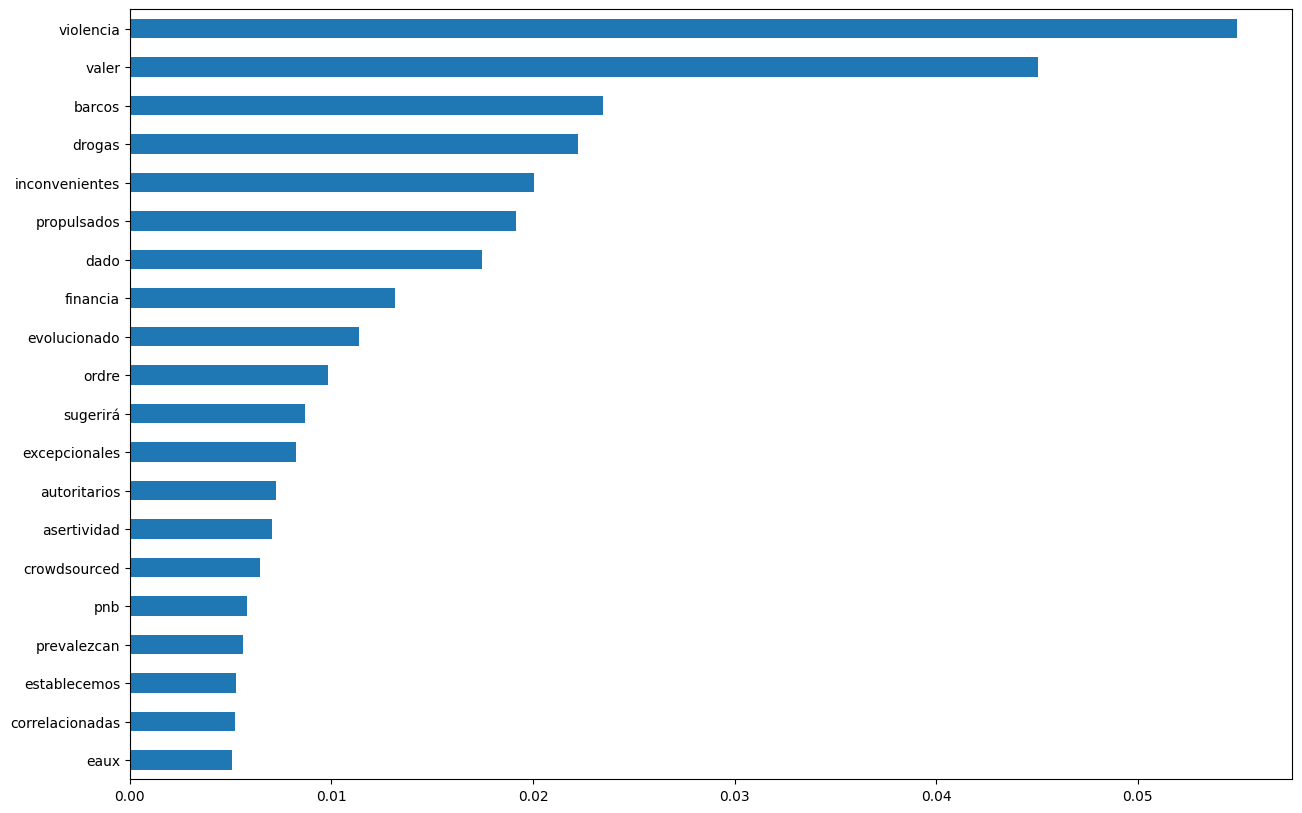

In [30]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

En la gráfica superior tenemos la relevancia de las palabras al momento de realizar proyecciones en los modelos. En este caso se puede observar que la palabra más significativa para hacer predicciones es "Violencia" con un valor de un poco más de 5%. La que le sigue es "Valer" con más del 4% de relevancia

In [31]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 95.62


Como se puede ver el número del arboles usados es de 100. De los cuales se puede observar una profundidad de 95.62

In [32]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

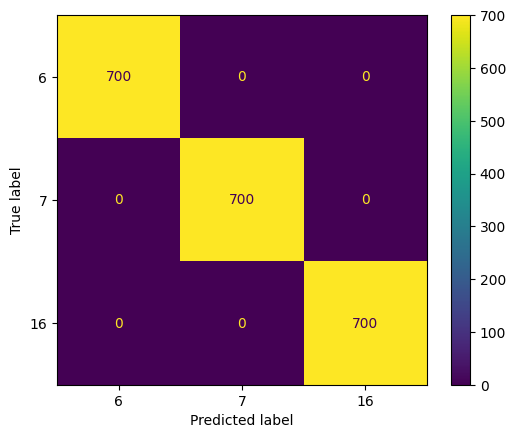

In [33]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

Como era de esperar el modelo al momento del entrenamiento no cuenta con ningpun de falsos positivos ni falsos negativos ni verdaderos negativos. Esto se puede observar en la totalidad de valores de la matriz de confusión presentes en la diagonal.

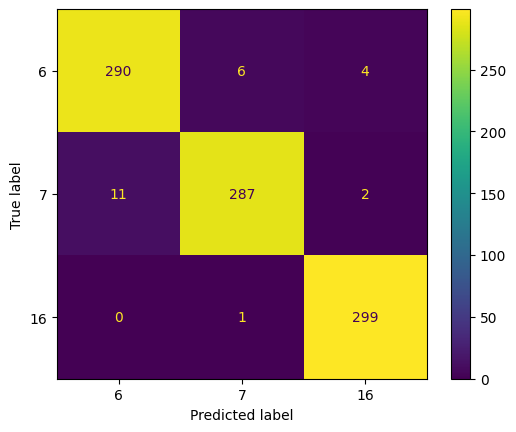

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

En el caso de la predicción del modelo podemos observar como hay una muy buena distribución de verdaderos positivos pero encontramos ciertos valores de falsos negativos, falsos positivos y verdaderos negativos. Para poder realizar una análisis más certero de la predicción del modelo haremos uso de la "Precision", "Recall" y "F1-score".

In [35]:
print("Precision:", precision_score(y_train, y_train_bow_predict, average='macro'))
print("Recall:", recall_score(y_train, y_train_bow_predict, average='macro'))
print("F1:", f1_score(y_train, y_train_bow_predict, average='macro'))

Precision: 1.0
Recall: 1.0
F1: 1.0


En el caso de entrenamiento los valores son de 1 por lo que se puede decir que el modelo es perfecto. En el caso de la predicción se puede observar que los valores son muy buenos, pero no perfectos. Esto se puede observar en los valores de "Precision", "Recall" y "F1-score" que son de 0.97, 0.97 y 0.97 respectivamente.

In [36]:
print("Precision:", precision_score(y_test, y_test_bow_predict, average='macro'))
print("Recall:", recall_score(y_test, y_test_bow_predict, average='macro'))
print("F1:", f1_score(y_test, y_test_bow_predict, average='macro'))

Precision: 0.973324498181532
Recall: 0.9733333333333333
F1: 0.9732726515563201


### 3.2. Primer acercamiento con TF-IDF
En este segundo modelo, se hace uso de TF-IDF, el cual se basa en la comparación del número de veces que aparece cada palabra en cada documento y también el número de documentos en los que aparece cada palabra.

In [37]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, lowercase=True)

In [38]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

In [39]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 16838


Como se puede observar se establecieron un total de 16838 palabras diferentes en el vocabulario. El método de construcción usado, como ya se mencionó es TF-IDF explicado previamente.

A continuación realizaremos un modelo de clasifiación haciendo uso del algortimos Random Forest. Este algoritmo es un método de aprendizaje supervisado que se basa en la construcción de un conjunto de árboles de decisión. La predicción se realiza por mayoría de votos de los árboles.

In [40]:
tfidf_model = RandomForestClassifier(random_state=3)

In [41]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<AxesSubplot: >

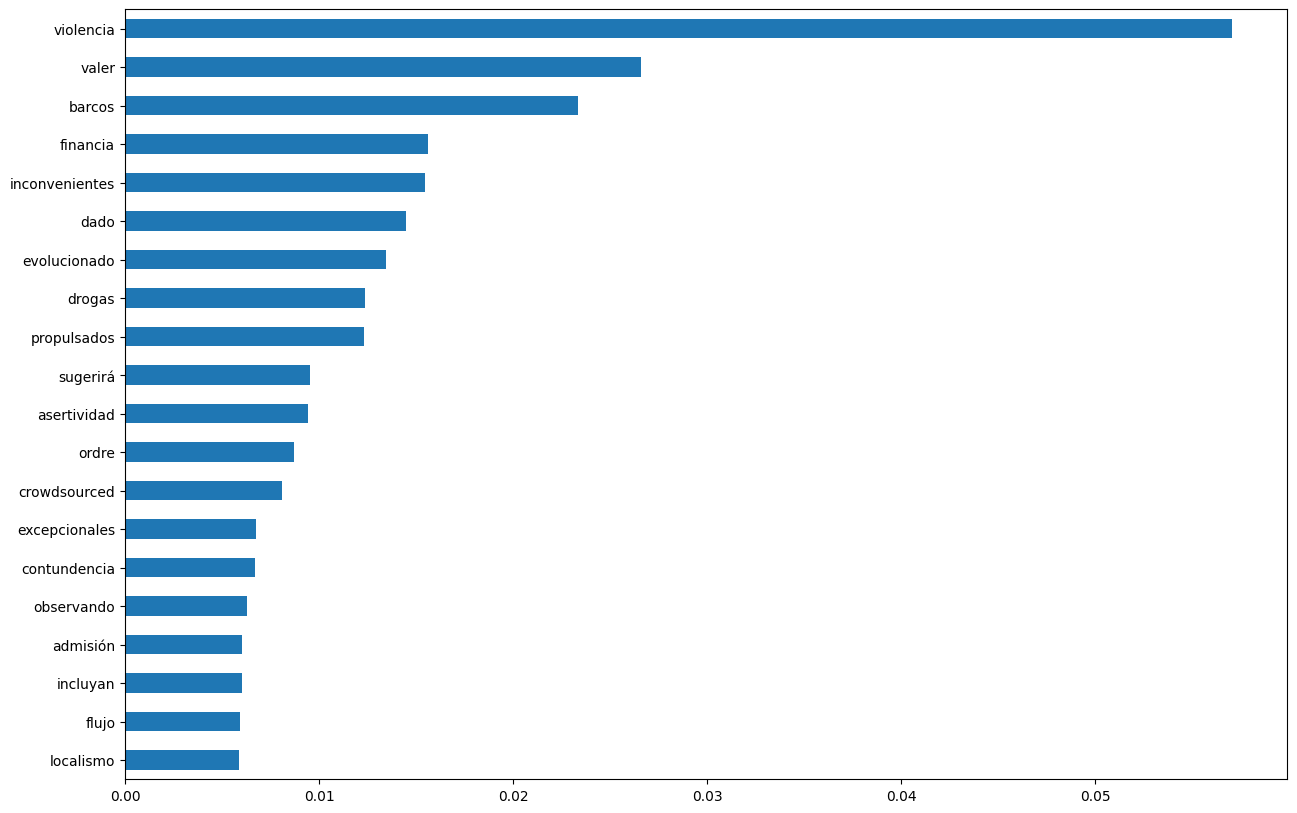

In [42]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

En la gráfica superior se observa la relevancia de las palabras al momento de realizar proyecciones en los modelos. En este caso se puede observar que la palabra más significativa para hacer predicciones es "violencia" con un valor de un poco más de 5%. La que le sigue es "valer" con poco mas del 2% de relevancia

In [43]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 90.51


Como se puede ver, el número del arboles usados es de 100. De los cuales se puede observar una profundidad de 90.51

In [44]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Textos_espanol"]))

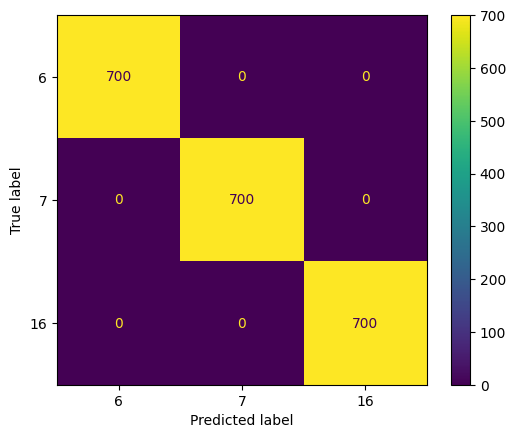

In [45]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

Como era de esperar el modelo al momento del entrenamiento no cuenta con ningún falso positivo, falso negativo ni verdadero negativo. Esto se puede observar en la totalidad de valores de la matriz de confusión presentes en la diagonal.

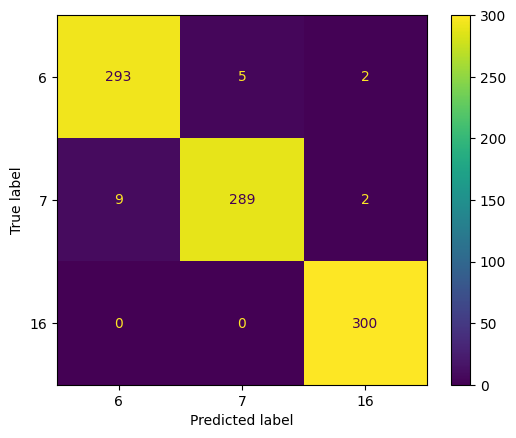

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

En el caso de la predicción del modelo podemos observar como hay una muy buena distribución de verdaderos positivos, pero también se encuentran ciertos valores de falsos negativos, falsos positivos y verdaderos negativos. Para poder realizar una análisis más certero de la predicción del modelo haremos uso de la "Precision", "Recall" y "F1-score".

In [47]:
print("Precision:", precision_score(y_train, y_train_tfidf_predict, average='macro'))
print("Recall:", recall_score(y_train, y_train_tfidf_predict, average='macro'))
print("F1:", f1_score(y_train, y_train_tfidf_predict, average='macro'))

Precision: 1.0
Recall: 1.0
F1: 1.0


En el caso de entrenamiento los valores de las métricas son de 1, por lo que se puede decir que el modelo es perfecto.

In [48]:
print("Precision:", precision_score(y_test, y_test_tfidf_predict, average='macro'))
print("Recall:", recall_score(y_test, y_test_tfidf_predict, average='macro'))
print("F1:", f1_score(y_test, y_test_tfidf_predict, average='macro'))

Precision: 0.9800113260129194
Recall: 0.98
F1: 0.9799544611393269


En el caso de la predicción se puede observar que los valores son muy buenos, pero no perfectos. Esto se puede observar en los valores de "Precision", "Recall" y "F1-score" que son de 0.97, 0.97 y 0.97 respectivamente. Por lo tanto, en gran parte de los casos el modelo predice de manera correcta el sdg asociado a un texto.